# Cosine shift function

Implement homogeneous to inhomogeneous transformation as described in "Spectral Solution with a Subtraction Method to Improve Accuracy" by Matthew Green (Santa Clara University).

## Imports

In [1]:
import numpy as np  
import scipy
import matplotlib.pyplot as plt 

## Calculate boundary derivatives and reconstruct trigonometric polynomial

In [162]:
class IPRReconstruction:
    def __init__(self, x, lam = 1, cutoff = 100): 
        self.cutoff                 = cutoff 
        self.lam                    = lam 
        W                           = self.directW(self.shiftx(x), int(len(x)/2), lam)
        self.p, self.l, self.u      = scipy.linalg.lu(W, permute_l=False)
        
    def poly(self, N): 
        return scipy.special.chebyt(N)
    
    def reconstruct(self, g): 
        f = np.poly1d([])
        for l, coeff in enumerate(g):
            f += coeff * self.poly(l)

        return f

    def __call__(self, x, order = 0):
        return self.rec.deriv(order)((x - self.s)*self.c) * self.c**order


    #Construct matrices T and V recursively for arbitrary lambda
    def directW(self, x, N, lam): 
        # Even 
        W = np.zeros((2*N, 2*N), dtype=complex)
        
        for l in range(2*N):
            W[:, l] = scipy.fft.fft(self.poly(l)(x))

        return W 

    
    def shiftx(self, x):
        dx = x[1] - x[0]
        self.a = x[0]
        self.b = x[-1]
        self.s = (self.a + self.b)/2
        self.c = 1 / ((self.b - self.a)/2)
        sx = (x - self.s) * self.c
        return  sx
        
    def gaussWithTruncation(self, A, B):
        """
        Solve Ax = B using Gaussian elimination and LU decomposition with truncation for stability of IPR
        """
        # LU decomposition with pivot
        p, l, u = scipy.linalg.lu(A, permute_l=False)
        return self.solveLUWithTruncation(B, p, l, u)
        
    
    def compute(self, psi, p = None, l = None, u = None):
        B = scipy.fft.fft(psi)

        if p is None:
            p = self.p 
        if l is None: 
            l = self.l
        if u is None: 
            u = self.u
            
        # forward substitution to solve for Ly = B
        y = np.zeros(B.size, dtype=complex)
        for m, b in enumerate((p.T @ B).flatten()):
            y[m] = b
            # skip for loop if m == 0
            if m:
                for n in range(m):
                    y[m] -= y[n] * l[m,n]
            y[m] /= l[m, m]

        # truncation for IPR
        c = np.abs(y) < self.cutoff * np.finfo(float).eps
        y[c] = 0

        # backward substitution to solve for y = Ux
        x = np.zeros(B.size, dtype=complex)
        lastidx = B.size - 1  # last index
        for midx in range(B.size):
            m = B.size - 1 - midx  # backwards index
            x[m] = y[m]
            if midx:
                for nidx in range(midx):
                    n = B.size - 1  - nidx
                    x[m] -= x[n] * u[m,n]
            x[m] /= u[m, m]
        self.rec = self.reconstruct(x)

In [130]:

#Differentiation matrix for forward derivatives
def fDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat 

#Differentiation matrix for backward derivatives
def bDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat 

#Vector with forward differences
def fDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff 

#Vector with backward differences
def bDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff 

def iterativeRefinement(A, b, tolerance = 1e-11): 
    C = np.linalg.solve(A, b) 
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual)) 

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual) 
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual)) 
        iteration += 1
        #print(f"After {iteration} iterations with residual error {residualError}")
        if iteration > 100:
            break

    #print(f"Finished in {iteration} iterations with residual error {residualError}")
    return C 

#Normalise input vector x to [0, 1]
def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

def cosineDiffVec(order, f, Dl, Dr):
    b = np.zeros(2*order, dtype=complex) 
    b[0] = f[ 0]
    b[1] = f[-1]
    #Even derivatives at left boundary
    for i in range(1, order):
        b[i*2    ] = Dl[2*i-1]/(np.pi)**(2*i) 

    #Even derivatives at right boundary
    for i in range(1, order): 
        b[i*2 + 1] = Dr[2*i-1]/(np.pi)**(2*i) 

    return b 

def cosineDiffMat(order): 
    A = np.zeros((order*2, order*2), dtype=complex)
    for i in range(order): 
        derivative  = 2 * i 
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j -- j**derivative
            #Every second derivative gives a minus sign -- (-1)**i 
            #Cosine evaluated at pi gives negative sign depending on wavelength -- (-1)**j
            A[2*i  , j-1] = j**derivative * (-1)**i
            A[2*i+1, j-1] = j**derivative * (-1)**i * (-1)**j 

    return A


def reconstruct(C, x, derivative_order = 0, t = 0):
    f = np.zeros(x.shape, dtype=complex)
    L = x[-1] - x[0]
    xeval = shiftx(x)
    for k in range(1, len(C) + 1):
        f += C[k-1] * (1j * k * np.pi / L) ** derivative_order * (np.exp(1j * (k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2
        #f += C[k-1] * (1j * k * np.pi/L) ** derivative_order * (np.cos(k * np.pi * xeval))# - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2

    return f

def getShiftFunction(f, order, x): 
    xeval = shiftx(x)
    dx = xeval[1] - xeval[0]
    A = fDiffMat (order, dx) 
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx) 
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)

    A = cosineDiffMat(int(order/2) + 1) 
    b = cosineDiffVec(int(order/2) + 1, f, Dl, Dr)
    C = iterativeRefinement(A, b)

    shift = reconstruct(C, x)

    if 0:
        print("Absolute mismatch at boundaries")
        for i in range(order): 
            di = reconstruct(C, x, i+1)
            L  = x[-1] - x[0]
            print(f"L: {np.abs(di[0] - Dl[i]/L**(i+1)):3.3f} R: {np.abs(di[-1] - Dr[i]/L**(i+1)):3.3f}")


    return shift, C

#Momentum vector for sine transform
def computeK(p, dx):
    N = len(p)
    M = 2 * ( N + 1 )
    n = np.arange(1, int(M/2)    )
    k = 2 * np.pi / ( M * dx ) * n
    return k


## Test subroutine to calculate boundary derivatives

In [177]:
x = np.linspace(0, 10, 32)
order = 9

def func(x, derivative_order=0): 
    return np.exp(x)
    #return np.real((1j*10)**derivative_order*np.exp(1j*10*x))

f = func(x)

#xeval = shiftx(x)
dx = x[1] - x[0]
A = fDiffMat (order, dx) 
b = fDiffVec (order, f)
Dl = iterativeRefinement(A, b)
A = bDiffMat (order, dx) 
b = bDiffVec (order,  f)
Dr = iterativeRefinement(A, b)
print("Relative mismatch at boundaries")
for i in range(order): 
    print(f"L: {np.abs(func(x[0], i+1) - Dl[i])/(np.abs(Dl[i])+1e-8):3.8f} R: {np.abs(func(x[-1], i+1) - Dr[i])/(np.abs(Dr[i])+1e-8):3.8f}")

Relative mismatch at boundaries
L: 0.00001473 R: 0.00000105
L: 0.00025603 R: 0.00001866
L: 0.00267509 R: 0.00020163
L: 0.02054250 R: 0.00158324
L: 0.10148230 R: 0.00953527
L: 0.90120283 R: 0.04546160
L: 0.59080081 R: 0.18050198
L: 1.50848629 R: 0.66921585
L: 0.77476275 R: 3.10672072


In [140]:
x = np.linspace(-0.2, 3, 256)
order = 6

f = func(x)

xeval = shiftx(x)
dx = x[1]-x[0]#xeval[1] - xeval[0]
A = fDiffMat (order, dx) 
b = fDiffVec (order, f)
Dl = iterativeRefinement(A, b)

A = bDiffMat (order, dx) 
b = bDiffVec (order,  f)


A = cosineDiffMat(int(order/2) + 1) 
b = cosineDiffVec(int(order/2) + 1, f, Dl, Dr)
C = iterativeRefinement(A, b)

shift = reconstruct(C, x)

def reconstruct(C, x, derivative_order = 0, t = 0):
    f = np.zeros(x.shape, dtype=complex)
    L = x[-1] - x[0]
    xeval = shiftx(x)
    for k in range(1, len(C) + 1):
        #f += C[k-1] * (1j * k * np.pi / L) ** derivative_order * (np.exp(1j * (k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2
        f += C[k-1] * (1j * k * np.pi ) ** derivative_order * (np.cos(k * np.pi * xeval))# - (k*np.pi / L)**2 / 2 * t)) + np.exp(1j * (-k * np.pi * xeval - (k*np.pi / L)**2 / 2 * t)))/2

    return f

print("Relative mismatch at boundaries")
for i in range(order): 
    di = reconstruct(C, x, i+1)
    print(f"L: {np.abs(di[0] - Dl[i])/(np.abs(Dl[i])+1e-8):3.3f} R: {np.abs(di[-1] - Dr[i])/(np.abs(Dr[i])+1e-8):3.3f}")

Relative mismatch at boundaries
L: 20.555 R: 21.356
L: 0.000 R: 0.000
L: 1108.457 R: 548.115
L: 0.000 R: 0.000
L: 249539.000 R: 98239.437
L: 0.000 R: 0.000


#### Compare with IPR

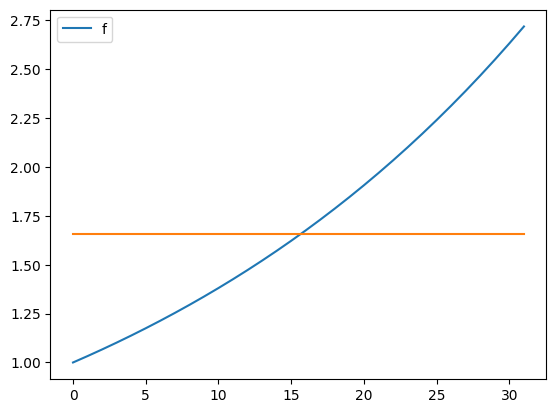

Relative mismatch at boundaries
L: 0.00000001 R: 0.00000001
L: 0.00000050 R: 0.00000020
L: 0.00001219 R: 0.00000488
L: 0.00021542 R: 0.00008881
L: 0.00281316 R: 0.00120324
L: 0.02574835 R: 0.01211006
L: 0.20524199 R: 0.09217331
L: 0.39749852 R: 0.63849974
L: 100000000.00000000 R: 271828182.84590453


In [181]:
x = np.linspace(0, 1, 32)
order = 9

def func(x, derivative_order=0): 
    return np.exp(x)
    #return np.real((1j*10)**derivative_order*np.exp(1j*10*x))

f = func(x)

ipr = IPRReconstruction(x, 1, 1e7)

plt.plot(f, label="f")
ipr.compute(f)
plt.plot(ipr(x, 8))
plt.legend()
plt.show()
#xeval = shiftx(x)
dx = x[1] - x[0]
Nrec = 32
lam = 1
lipr = IPRReconstruction(x[:Nrec], lam, 1e7)
lipr.compute(f[:Nrec])
ripr = IPRReconstruction(x[-Nrec:], lam, 1e7)
ripr.compute(f[-Nrec:])
Dl = []
Dr = []
for i in range(1, order + 1):
    Dl.append(lipr(x[0], i))
    Dr.append(ripr(x[-1], i))
    
print("Relative mismatch at boundaries")
for i in range(order): 
    print(f"L: {np.abs(func(x[0], i+1) - Dl[i])/(np.abs(Dl[i])+1e-8):3.8f} R: {np.abs(func(x[-1], i+1) - Dr[i])/(np.abs(Dr[i])+1e-8):3.8f}")

## Test subroutine to create shift function matching boundary conditions

In [5]:
bc_l = []
bc_r = []
for i in range(order):
    bc_l.append((i + 1,   Dl[i]))
    bc_r.append((i + 1,   Dr[i]))
bc_type=(bc_l, bc_r)

poly  = scipy.interpolate.make_interp_spline([x[0], x[-1]], [f[0], f[-1]], k = 2 * order + 1, bc_type=bc_type, axis=0)

print("Relative mismatch at boundaries")
for i in range(order): 
    print(f"L: {np.abs(poly(x[0], i+1) - Dl[i])/(np.abs(Dl[i])+1e-8):3.3f} R: {np.abs(poly(x[-1], i+1) - Dr[i])/(np.abs(Dr[i])+1e-8):3.3f}")

Relative mismatch at boundaries
L: 0.001 R: 0.000
L: 0.000 R: 0.000
L: 0.002 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000
L: 0.000 R: 0.000


/home/calab912/.local/lib/python3.8/site-packages/scipy/interpolate/_bsplines.py:1343: ComplexWarning: Casting complex values to real discards the imaginary part
  rhs[:nleft] = deriv_l_vals.reshape(-1, extradim)
/home/calab912/.local/lib/python3.8/site-packages/scipy/interpolate/_bsplines.py:1346: ComplexWarning: Casting complex values to real discards the imaginary part
  rhs[nt - nright:] = deriv_r_vals.reshape(-1, extradim)


In [123]:
from scipy.fft import fft, dct, dst

import numpy as np

fft(np.array([0, 1, -1])).imag, dst(np.array([1, -1]), 1)

(array([-0.        , -1.73205081,  1.73205081]),
 array([-0.        ,  3.46410162]))

## Test obtaining shift function via IDCT

In [166]:
def makouldct(x): 
    N = len(x) 
    k = np.arange(N)
    v = np.empty_like(x)
    v[:(N-1)//2+1] = x[::2]

    if N % 2: # odd length
        v[(N-1)//2+1:] = x[-2::-2]
    else: # even length
        v[(N-1)//2+1:] = x[::-2]

    V = fft(v)

    V *= 2 * np.exp(-1j*np.pi*k/(2*N))
    return V.real



makouldct(np.array([1., 2., 1.]))

array([ 8.00000000e+00, -2.22044605e-16, -2.00000000e+00])

In [34]:

def mydst(f): 
    fftf = np.concatenate([f, -np.flip(f)[1:-1]])
    return scipy.fft.fft(fftf)

a = np.array([2, 4, 5, 6])
mydst(a), scipy.fft.dst(a, 1)

(array([ 8. -0.j        , -4.-15.58845727j,  8. +1.73205081j,
        -4. -0.j        ,  8. -1.73205081j, -4.+15.58845727j]),
 array([26.52358133, -8.78402263,  4.63676972, -2.80016899]))

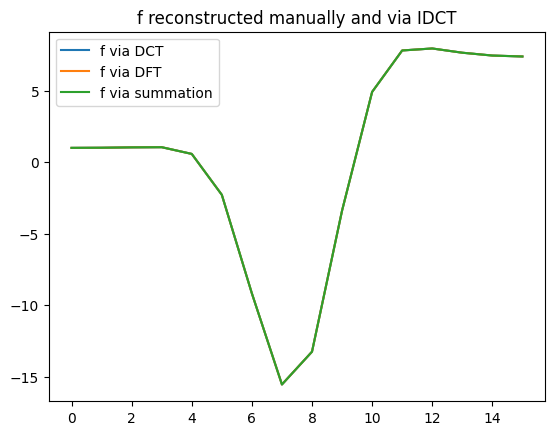

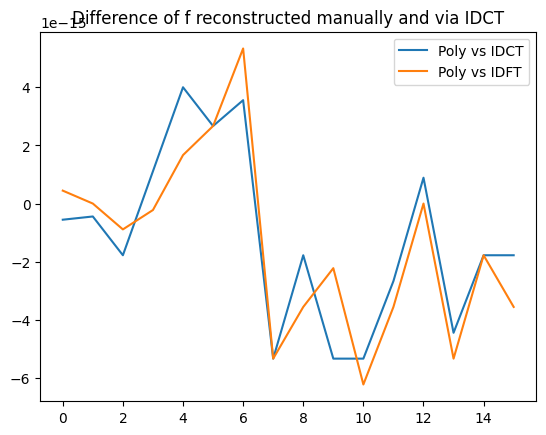

In [97]:
x = np.linspace(0, 2, 128)
dx = x[1] - x[0]
def func(x, derivative_order=0): 
    return np.exp(x) 
N = 10
N_derivative = 6

f = func(x)
shift, C = getShiftFunction(f, N, x) 

def myidct(dcthat): 
    dfthat = np.concatenate([dcthat, np.flip(dcthat)[1:-1]])
    return scipy.fft.ifft(dfthat)

def reconstructDCT(C, N): 
    dctcoeff = np.pad(C, (1, N - len(C) - 1), mode="constant")
    dctcoeff *= len(dctcoeff) - 1
    return dctcoeff, scipy.fft.idct(dctcoeff, type=1)

orig = np.pad(C, (1, 0), mode="constant")

x = np.linspace(0, 2, 16)
f = reconstruct(C,x)
dctcoeff, f2 = reconstructDCT(C, len(f))
f3 = myidct(dctcoeff)[:len(x)]
plt.title("f reconstructed manually and via IDCT")
plt.plot(f2, label="f via DCT")
plt.plot(f3, label="f via DFT")
plt.plot(f, label="f via summation")
plt.legend()
plt.show()
plt.title("Difference of f reconstructed manually and via IDCT")
plt.plot(f-f2, label="Poly vs IDCT")
plt.plot(f-f3, label="Poly vs IDFT")
plt.legend()
plt.show()

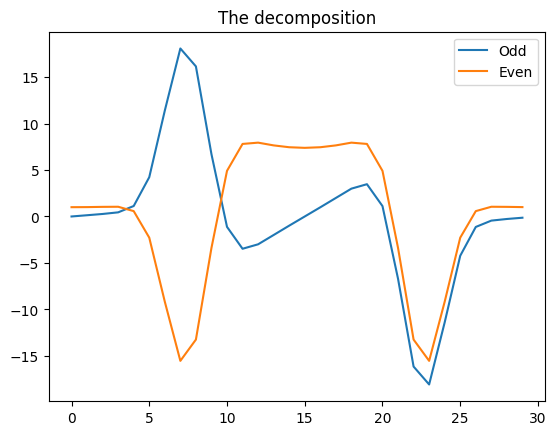

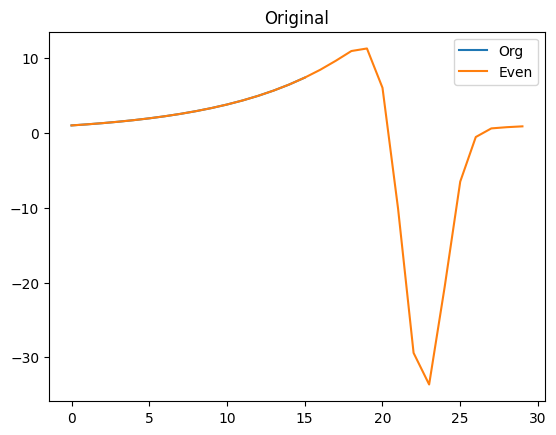

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


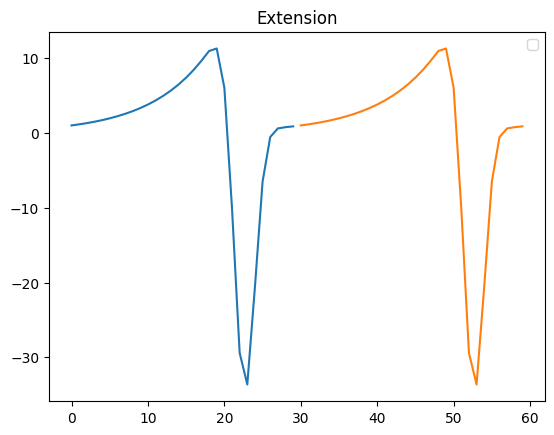

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


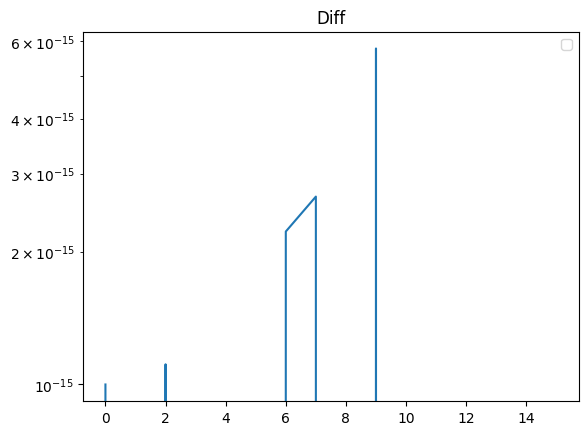

In [5]:
x = np.linspace(0, 2, 128)
dx = x[1] - x[0]
def func(x, derivative_order=0): 
    return np.exp(x) 
N = 10
N_derivative = 6

f = func(x)
shift, C = getShiftFunction(f, N, x) 
    
def mydst(f): 
    fftf = np.concatenate([f, -np.flip(f)[1:-1]])
    return scipy.fft.fft(fftf)

def dct2dft(dcthat):
    dfthat = np.concatenate([dcthat, np.flip(dcthat)[1:-1]])
    return dfthat 

def myidct(dcthat): 
    return scipy.fft.ifft(dct2dft(dcthat))

def reconstructDCT(C, N): 
    dctcoeff = np.pad(C, (1, N - len(C) - 1), mode="constant")
    dctcoeff *= len(dctcoeff) - 1
    return dctcoeff, scipy.fft.idct(dctcoeff, type=1)

x = np.linspace(0, 2, 16)
dx = x[1] - x[0]
f = func(x)
dctcoeff, shift = reconstructDCT(C, len(f))
hom = f - shift
dfteven = dct2dft(dctcoeff) 
dftodd  = mydst(hom)

plt.title("The decomposition")
odd = scipy.fft.ifft(dftodd)
even = scipy.fft.ifft(dfteven)
sum = odd + even 
plt.plot(odd, label="Odd")
plt.plot(even, label="Even")
plt.legend()
plt.show()
plt.title("Original")
plt.plot(f, label="Org")
plt.plot(sum, label="Even")
plt.legend()
plt.show()
plt.title("Extension")
plt.plot(np.arange(len(sum)), sum)
plt.plot(np.arange(len(sum), 2 * len(sum)), sum)
plt.legend()
plt.show()

plt.title("Diff")
plt.plot(f - sum[:len(f)])
plt.yscale("log")
plt.legend()
plt.show()

In [35]:
import spectral_derivative as sd 


x = np.linspace(0, 2, 64)
dx = x[1] - x[0]
f = func(x)

mass = np.sum(np.abs(f)**2)
shift, C = getShiftFunction(f, N, x) 
dctcoeff, shift = reconstructDCT(C, len(f))
hom = f - shift

minh = np.sum(np.abs(shift)**2)
mhom = np.sum(np.abs(hom)**2)
mmix = 2 * np.sum(np.abs(hom*shift))

dfteven = dct2dft(dctcoeff) 
dftodd  = mydst(hom)


dftsum = dftodd + dfteven 

plt.title("Extended spectrum")
plt.plot(dftsum.real) 
plt.plot(dftsum.imag) 
plt.show() 

k = sd.computeK(dftsum, dx, sd.PERIODIC)
org = scipy.fft.ifft(dftsum)

dftsum = dftsum * np.exp(1j * 0.5 * (-1) * k**2 * 1e-2) 
rec = scipy.fft.ifft(dftsum)

homev = 
plt.title("Original")
plt.plot(f, label="Org")
plt.plot(rec, label="Rec")
plt.legend()

recmass = np.sum(np.abs(rec[:len(f)])**2) 
mass, recmass, mass - recmass


SyntaxError: invalid syntax (4165206994.py, line 34)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[-3.33066907e-16+0.00000000e+00j -9.97036746e+01-9.97036746e+01j
 -3.55621784e+01-3.55621784e+01j  9.83212700e+01+9.83212700e+01j
  1.14593440e+01+1.14593440e+01j -5.35286688e+01-5.35286688e+01j
 -3.18947660e+00-3.18947660e+00j  1.98763956e+01+1.98763956e+01j
  6.32582826e-01+6.32582826e-01j -4.74785852e+00-4.74785852e+00j
 -7.24596048e-02-7.24596048e-02j  6.20322598e-01+6.20322598e-01j
  2.62723510e-03+2.62723510e-03j -2.47405863e-02-2.47405863e-02j
  8.14171936e-05+8.14171936e-05j  4.47301067e-15+1.06581410e-14j
 -8.14171936e-05-8.14171936e-05j  2.47405863e-02+2.47405863e-02j
 -2.62723510e-03-2.62723510e-03j -6.20322598e-01-6.20322598e-01j
  7.24596048e-02+7.24596048e-02j  4.74785852e+00+4.74785852e+00j
 -6.32582826e-01-6.32582826e-01j -1.98763956e+01-1.98763956e+01j
  3.18

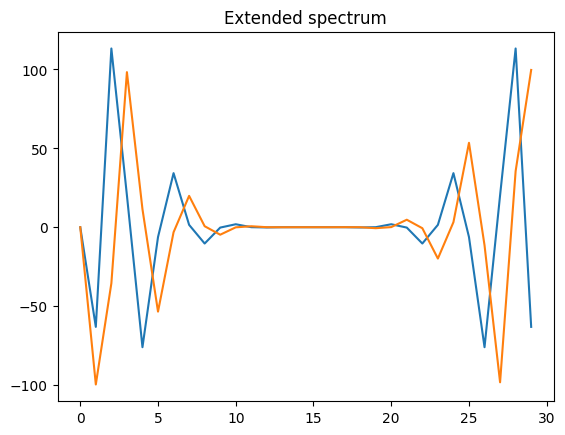

weight ratio of dft coeffs after time step: 1.000000000000000e+00
The weight of my reconstruction:  48655.08966158
Weight ratio 1.000000000000000e+00
Weight ratio after time step: 1.000000000055993e+00 1.000000000055994e+00


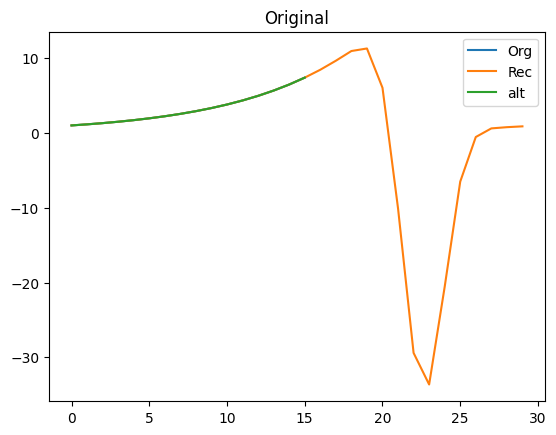

In [65]:
import spectral_derivative as sd 


x = np.linspace(0, 2, 16)
dx = x[1] - x[0]
f = func(x)

mass = np.sum(np.abs(f)**2)
shift, C = getShiftFunction(f, N, x) 
dctcoeff, shift = reconstructDCT(C, len(f))
hom = f - shift

if 0:
    plt.title("odd")
    plt.plot(hom)
    plt.show()

    plt.title("even")
    plt.plot(shift)
    plt.show()

dfteven = dct2dft(dctcoeff) 
dftodd  = mydst(hom)
dstcoeff = np.pad(scipy.fft.dst(hom[1:-1], 1), (1, 1), mode="constant")

def getEven(f):
    return np.pad((f[1:] + np.flip(f[1:]))/2, (1, 0), mode="constant")

def getOdd(f):
    return np.pad((-f[1:] + np.flip(f[1:]))/(2j), (1, 0), mode="constant")

def myifft(fhat, oldweight):
    dstcoeff = getOdd (fhat)[ :len(hom) ]
    dctcoeff = getEven(fhat)[ :len(shift)]
    myweight = np.sum(np.abs(-1j*dstcoeff + dctcoeff)**2)
    print("The weight of my reconstruction: ", myweight)
    print(f"Weight ratio {oldweight/myweight:10.15e}")
    odd  =  np.pad(scipy.fft.idst(dstcoeff[1:-1], 1), (1, 1), mode="constant")
    even =  scipy.fft.idct(dctcoeff, 1) 

    if 0:
        plt.title("odd")
        plt.plot(odd.real)
        plt.plot(odd.imag)
        plt.plot(hom, label="shift")
        plt.legend()
        plt.show()
        plt.title("even")
        plt.plot(even.real)
        plt.plot(even.imag)
        plt.plot(shift, label="hom")
        plt.legend()
        plt.show()
    return odd + even 

eventest = getEven(dfteven) 
print(dfteven - eventest)
oddtest = getOdd(dftodd) 
print(dftodd -oddtest) 
if 0:
    plt.title("Even")
    plt.plot(dfteven.real, label="real")
    plt.plot(dfteven.imag, label="imag")
    plt.legend()
    plt.show()

    plt.title("Even test")
    plt.plot(eventest.real, label="real")
    plt.plot(eventest.imag, label="imag")
    plt.legend()
    plt.show()

    plt.title("Odd")
    plt.plot(dftodd.real, label="real")
    plt.plot(dftodd.imag, label="imag")
    plt.legend()
    plt.show()
    plt.title("Odd test")
    plt.plot(oddtest.real, label="real")
    plt.plot(oddtest.imag, label="imag")
    plt.legend()
    plt.show()
dftsum = dftodd + dfteven 

dftweight = np.sum(np.abs(dftsum[:len(f)])**2)
dcstweight = np.sum(np.abs(dctcoeff + -1j*dstcoeff)**2)
print("The weight of our weights: ", mass, dftweight, dcstweight, dftweight/mass*np.sqrt(np.pi))
plt.title("Extended spectrum")
plt.plot(dftsum.real) 
plt.plot(dftsum.imag) 
plt.show() 

k = sd.computeK(dftsum, dx, sd.PERIODIC)
dftsum = dftsum * np.exp(1j * 0.5 * (-1) * k**2 * 1e-4)


dftweightafterevol = np.sum(np.abs(dftsum[:len(f)])**2)

print(f"weight ratio of dft coeffs after time step: {dftweight/dftweightafterevol:10.15e}")
rec = scipy.fft.ifft(dftsum)

alt = myifft(dftsum, dftweight) 
plt.title("Original")
plt.plot(f, label="Org")
plt.plot(rec, label="Rec")
plt.plot(alt, label="alt")
plt.legend()

recmass = np.sum(np.abs(rec[:len(f)])**2) 
recmass2 = np.sum(np.abs(alt)**2) 

print(f"Weight ratio after time step: {mass/recmass:10.15e} {mass/recmass2:10.15e}")

## Check how to best conserve mass

/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


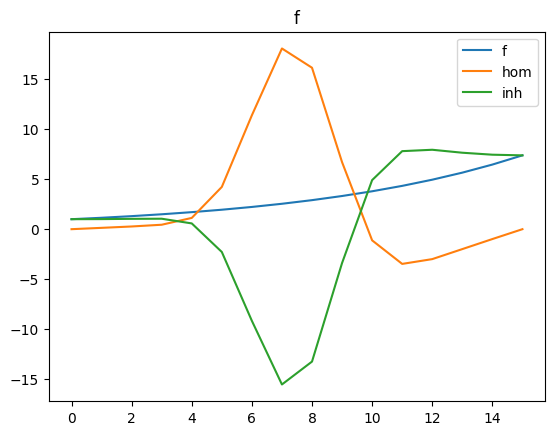

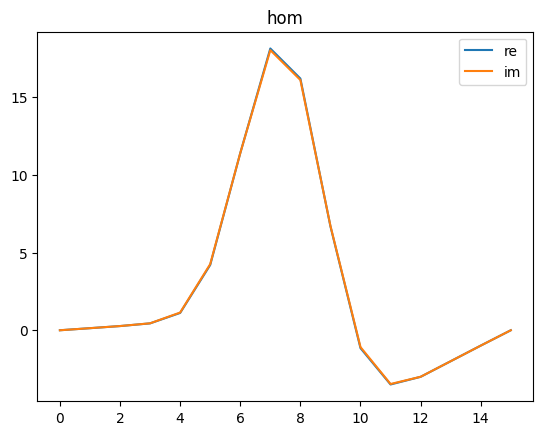

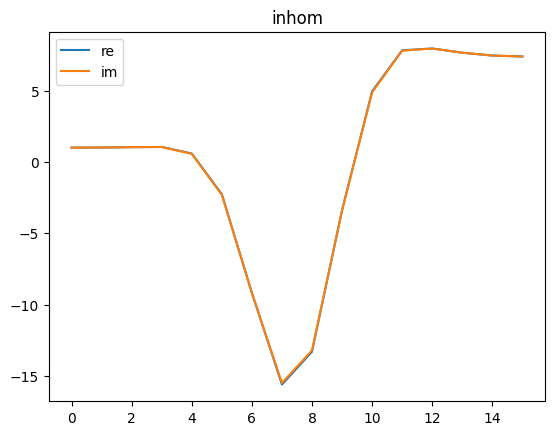

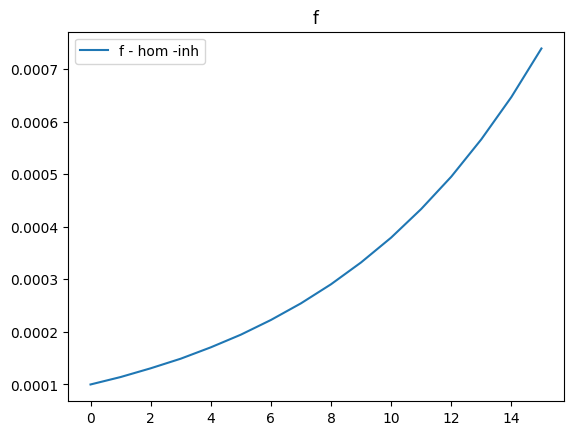

(-2839.2810322109663,
 1619.8393858304494,
 1679.405243158346,
 1619.839385830449,
 1679.4052431583473,
 48595.181574913484,
 48714.21279375606,
 4.547473508864641e-13,
 -1.3642420526593924e-12,
 1.0294405683453078e-07)

In [193]:
x = np.linspace(0, 2, 128)
dx = x[1] - x[0]
def func(x, derivative_order=0): 
    return np.exp(x) + 1j * np.exp(x)
N = 10
N_derivative = 6

f = func(x)
shift, C = getShiftFunction(f, N, x) 
    
def mydst(f): 
    fftf = np.concatenate([f, -np.flip(f)[1:-1]])
    return scipy.fft.fft(fftf)

def dct2dft(dcthat):
    dfthat = np.concatenate([dcthat, np.flip(dcthat)[1:-1]])
    return dfthat 

def myidct(dcthat): 
    return scipy.fft.ifft(dct2dft(dcthat))

def reconstructDCT(C, N): 
    dctcoeff = np.pad(C, (1, N - len(C) - 1), mode="constant")
    dctcoeff *= len(dctcoeff) - 1
    return dctcoeff, scipy.fft.idct(dctcoeff, type=1)

x  = np.linspace(0, 2, 16)
dx = x[1] - x[0]
f  = func(x)
dctinh, inh = reconstructDCT(C, len(f))
hom         = f - inh

plt.title("f") 
plt.plot(f, label="f") 
plt.plot(hom, label="hom") 
plt.plot(inh, label="inh") 
plt.legend()
plt.show()

dsthom  = scipy.fft.dst(hom[1:-1], 1) 

def mass(f):
    return np.sum(np.abs(f)**2)
mf   = mass(f)
mhom = mass(hom)
minh = mass(inh)


mhomhat = mass(dsthom)
minhhat = mass(dctinh) 

khom = sd.computeK(dsthom, dx, sd.DD)
kinh = sd.computeK(dctinh, dx, sd.NN)

dsthom = dsthom * np.exp(-1j * khom**2 * 1e-4)
dctinh = dctinh * np.exp(-1j * kinh**2 * 1e-4)

hom = np.pad(scipy.fft.idst(dsthom, 1) , (1,1), mode="constant")

inh = scipy.fft.idct(dctinh, 1)

plt.title("hom") 
plt.plot(hom.real, label="re")
plt.plot(hom.imag, label="im")
plt.legend()
plt.show() 

plt.title("inhom") 
plt.plot(inh.real, label="re")
plt.plot(inh.imag, label="im")
plt.legend()
plt.show() 

fup = hom + inh 

plt.title("f") 
plt.plot(f - hom - inh, label="f - hom -inh")
plt.legend()
plt.show()

mhom2 = mass(hom)
minh2 = mass(inh)
mfup  = mass(fup) 
mf - mhom - minh, mhom, minh, mhom2, minh2, mhomhat, minhhat, mhom - mhom2, minh - minh2, mf - mfup

from scipy.fft import fft, dct

import numpy as np

fft(np.array([4., 3., 5., 10., 5., 3.])).real
array([ 30.,  -8.,   6.,  -2.,   6.,  -8.])

dct(np.array([4., 3., 5., 10.]), 1)
array([ 30.,  -8.,   6.,  -2.])

## Test continuity of derivatives after shift using FFT

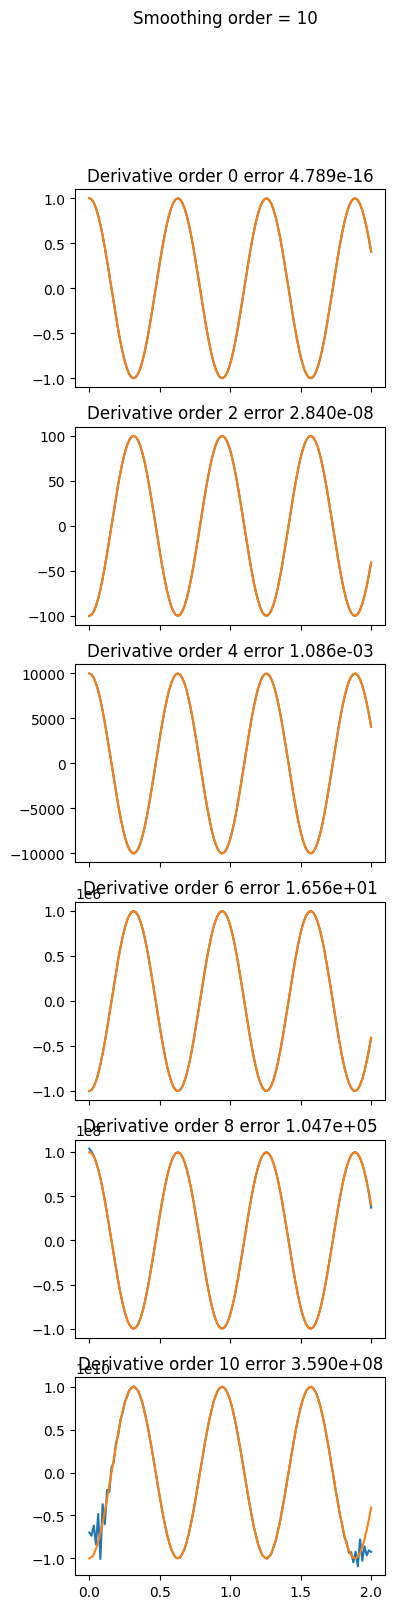

In [75]:
x = np.linspace(0, 2, 128)
dx = x[1] - x[0]
def func(x, derivative_order=0): 
    return np.real((1j*10)**derivative_order*np.exp(1j*10*x))
    #return np.imag((1j*np.pi)**derivative_order*np.exp(1j*np.pi*x))

f = func(x)

N = 10
N_derivative = 6

def getLinearShift(f, x):
    f0 = f[0]
    f1 = f[-1]
    x0 = x[0]
    x1 = x[-1]

    slope = (f1 - f0) / (x1 - x0)
    return f0 + slope * ( x - x0 )
f        = f - 
shift, C = getShiftFunction(f, N, x) 
hom  = f - shift
fhat = scipy.fft.dst(hom[1:-1], type=1) 
fig, ax = plt.subplots(N_derivative, 1, sharex=True, figsize=(4,N_derivative*3)) 
fig.suptitle(f"Smoothing order = {N}")
for i in range(N_derivative): 
    k    = computeK(fhat, dx)
    frec = scipy.fft.idst(fhat * (1j*k)**(i*2), type=1)
    frec = np.pad(frec, (1, 1), mode="constant")
    
    reco = reconstruct(C, x, i*2)
    sumo = frec + reco 

    fref = func(x, i*2) 
    ax[i].set_title(f"Derivative order {i*2} error {np.mean(np.abs(sumo-fref)):3.3e}")
    ax[i].plot(x, sumo, label="sum") 
    ax[i].plot(x, fref, label="ref") 
    
plt.savefig(f"cosine_with_truncation_order_{N}.png")
plt.show()
plt.close()

## Test decay of Fourier coefficients

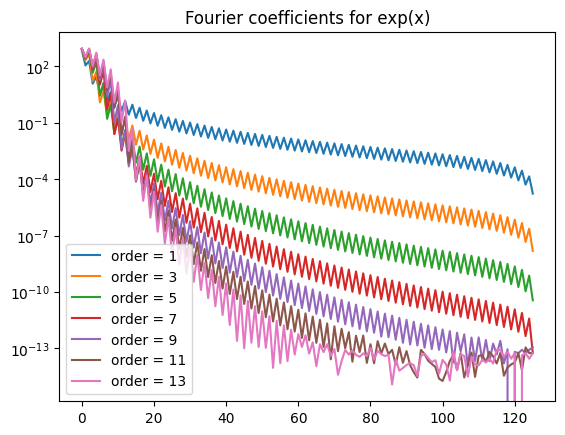

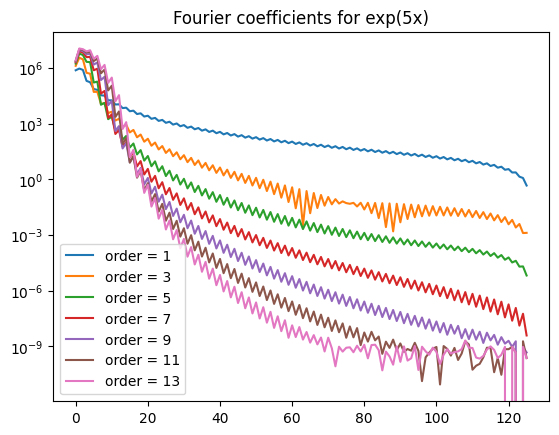

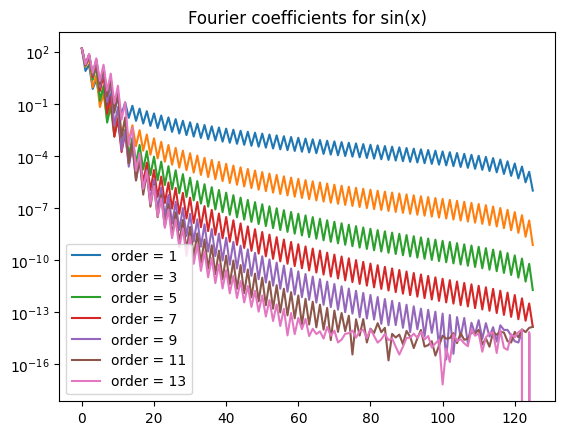

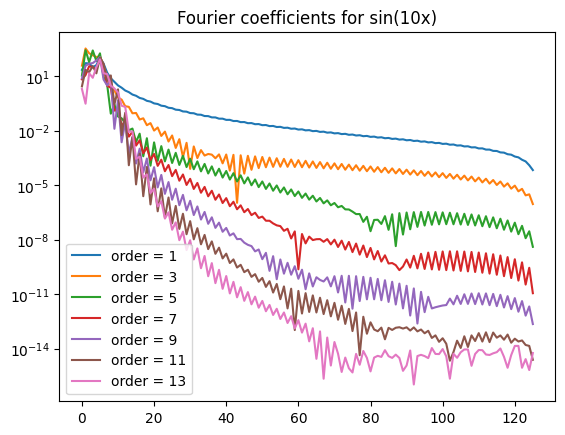

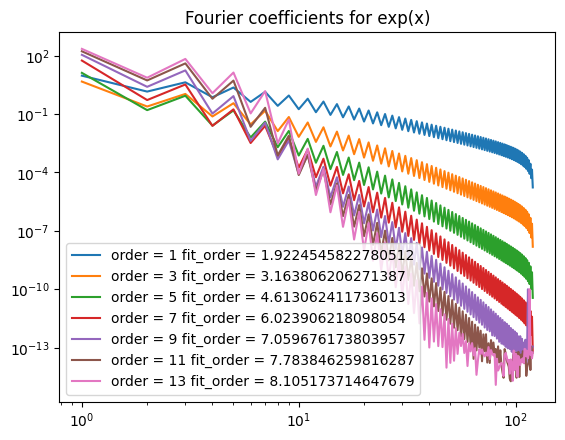

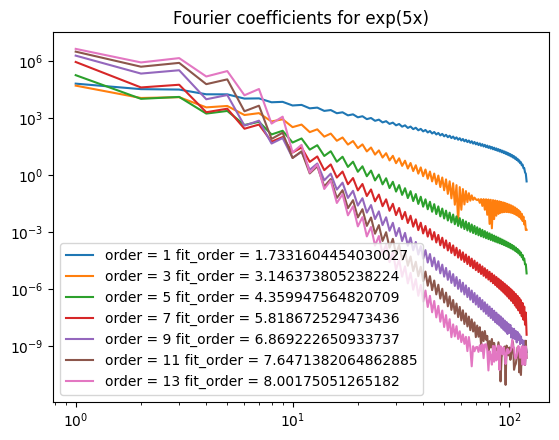

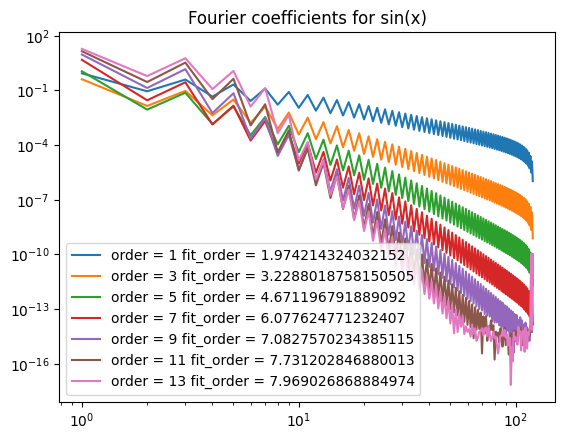

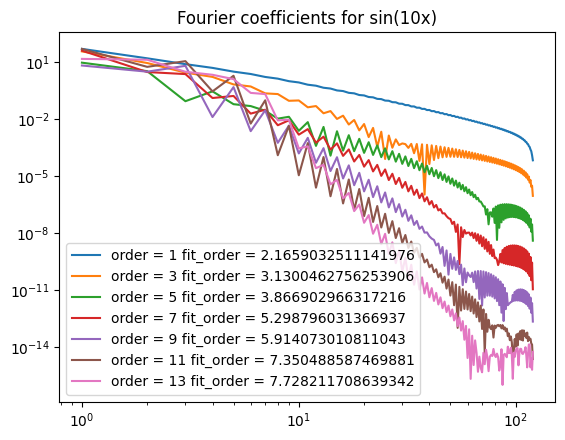

In [6]:
x = np.linspace(0, 2, 128)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    plt.yscale("log") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        plt.plot(np.abs(fhat), label=f"order = {order}") 
    plt.legend()
    plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C = getShiftFunction(f, order, x)
        hom = f - shift 
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        y    = np.abs(fhat)
        y[y==0] = 1e-10
        y    = y[6:]
        r    = np.arange(1, len(y)+1)
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 

## Test implementation in spectral_derivative.py

In [10]:
import spectral_derivative as sd 


/home/calab912/Documents/fdm-hybrid-scheme/demonstration/spectral_derivative.py:639: ComplexWarning: Casting complex values to real discards the imaginary part
  B[i] = poly( x, i * 2)
/home/calab912/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(128,) (128,)
(128,) (128,)
(128,) (128,)
(128,) (128,)
(128,) (128,)
(128,) (128,)


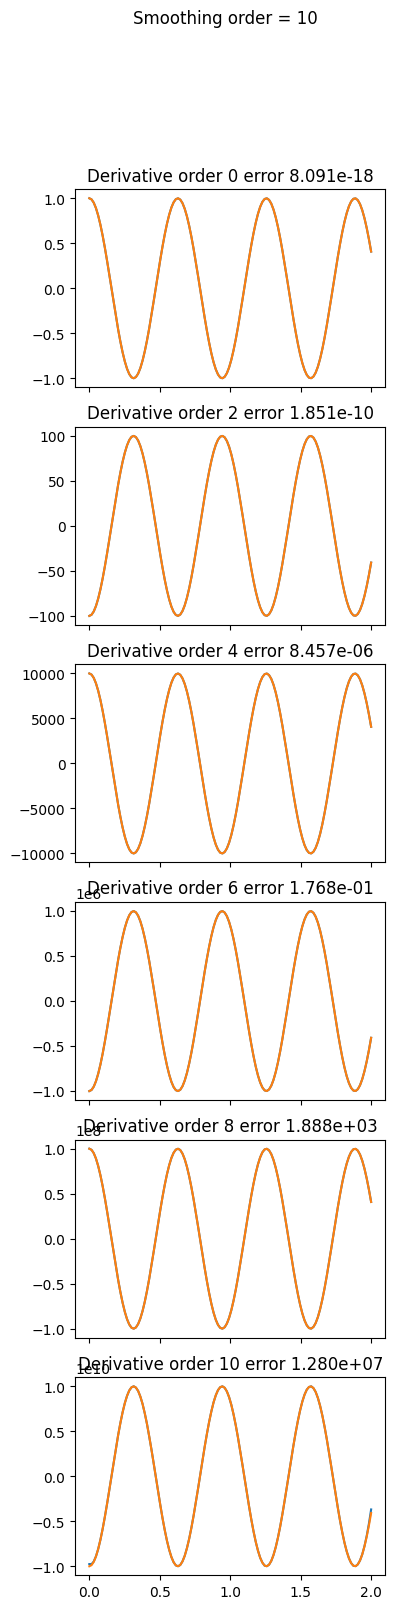

In [20]:
x = np.linspace(0, 2, 128)
dx = x[1] - x[0]
def func(x, derivative_order=0): 
    return np.real((1j*10)**derivative_order*np.exp(1j*10*x))

f = func(x)

N = 10
N_derivative = 6

B, poly = sd.getShiftFunction(x, f, mode=sd.M_COSINE, derivative_mode=sd.ONE_SIDED, lb=0, rb=0, chop=False, N=order)
hom  = f - B[0]
fig, ax = plt.subplots(N_derivative, 1, sharex=True, figsize=(4,N_derivative*3)) 
fig.suptitle(f"Smoothing order = {N}")
for i in range(N_derivative): 
    frec = np.copy(hom[1:-1])
    for j in range(i):
        frec, k= sd.laplacianDtt1D(frec, dx, sd.DD) 
    frec = sd.restoreBC(frec, sd.DD) 
    
    reco = poly(x, i*2)
    print(frec.shape, reco.shape)
    sumo = frec + reco 

    fref = func(x, i*2) 
    ax[i].set_title(f"Derivative order {i*2} error {np.mean(np.abs(sumo-fref)):3.3e}")
    ax[i].plot(x, sumo, label="sum") 
    ax[i].plot(x, fref, label="ref") 
    
plt.savefig(f"cosine_order_{N}.png")
plt.show()
plt.close()

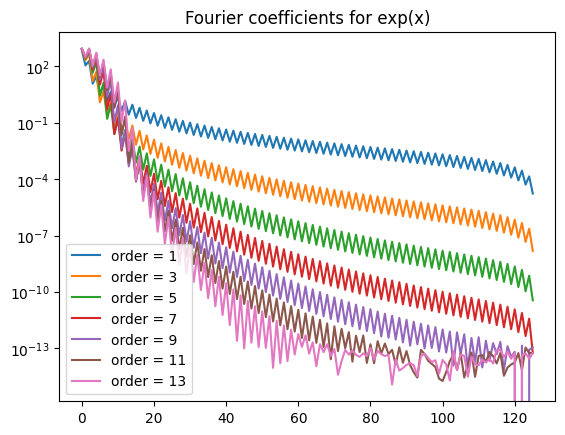

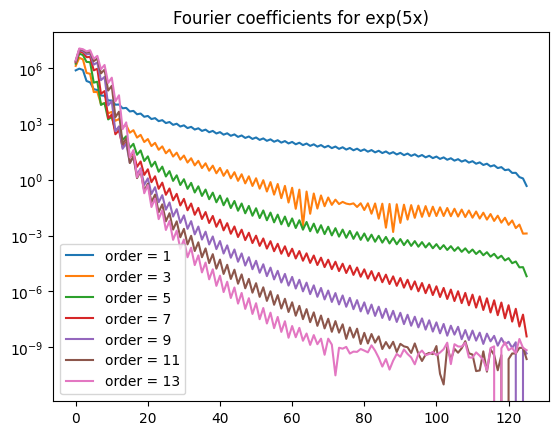

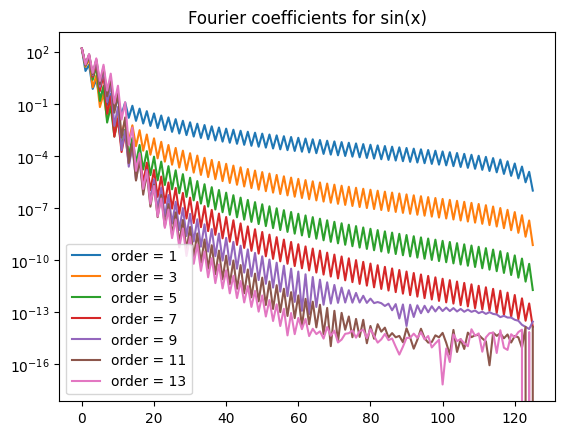

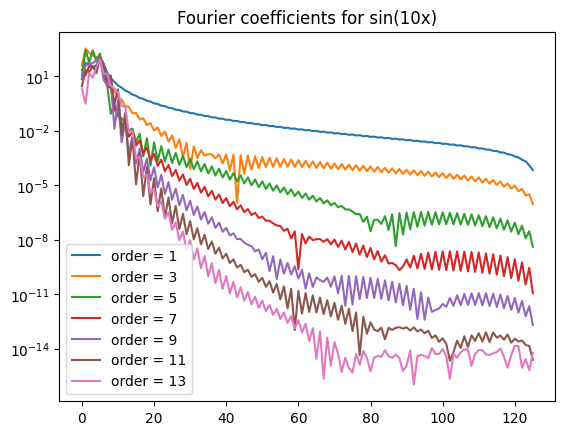

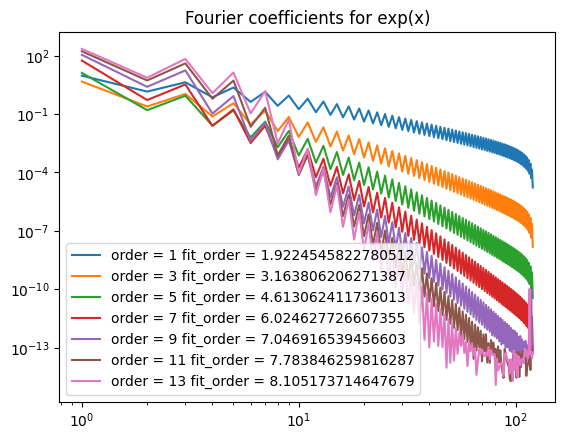

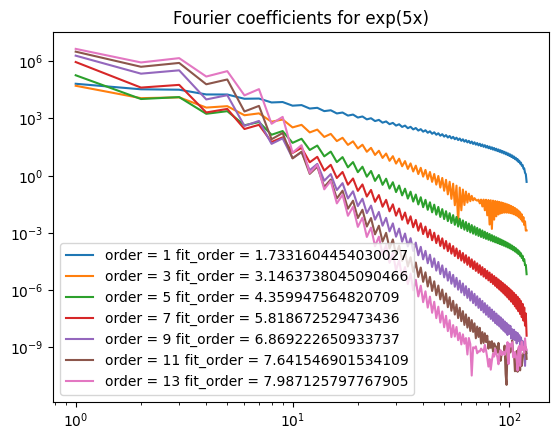

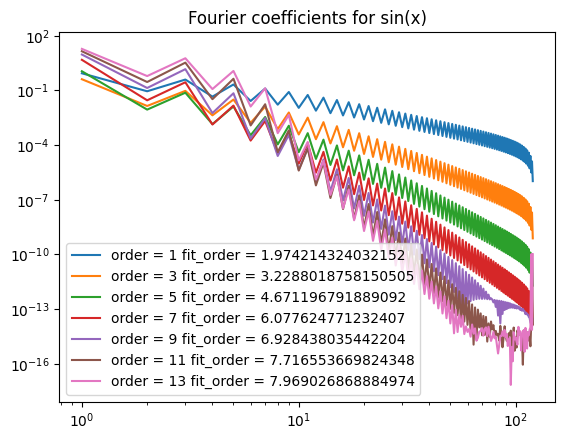

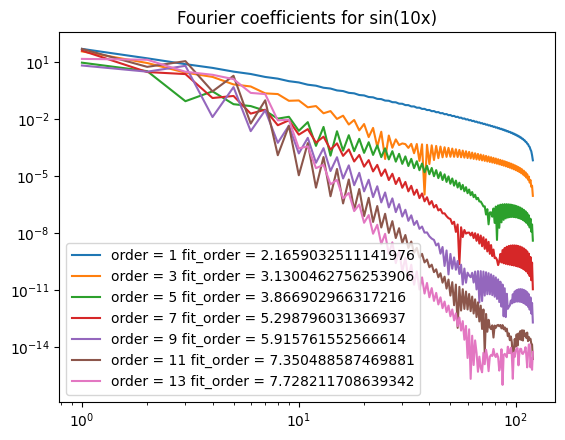

In [23]:

x = np.linspace(0, 2, 128)
fs = [np.exp(x), np.exp(5*x), np.sin(x), np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    plt.yscale("log") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        B, poly = sd.getShiftFunction(x, f, mode=sd.M_COSINE, derivative_mode=sd.ONE_SIDED, lb=0, rb=0, chop=False, N=order)
        hom = f - B[0]
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        plt.plot(np.abs(fhat), label=f"order = {order}") 
    plt.legend()
    plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        B, poly = sd.getShiftFunction(x, f, mode=sd.M_COSINE, derivative_mode=sd.ONE_SIDED, lb=0, rb=0, chop=False, N=order)
        hom = f - B[0]
        fhat = scipy.fft.dst(hom[1:-1], type=1) 
        y    = np.abs(fhat)
        y[y==0] = 1e-10
        y    = y[6:]
        r    = np.arange(1, len(y)+1)
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 